In [45]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd #to work with csv files

#import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score

#pre-processing of text
import string
import re

#import classifiers from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [46]:
data = pd.read_csv('./data/Full-Economic-News-DFE-839861.csv',encoding="ISO-8859-1")
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [47]:
data["relevance"].value_counts()/data.shape[0]

relevance
no          0.821375
yes         0.177500
not sure    0.001125
Name: count, dtype: float64

In [48]:
data = data[data['relevance'] != 'not sure']

In [49]:
data['relevance'].value_counts()

relevance
no     6571
yes    1420
Name: count, dtype: int64

In [50]:
data['relevance'] = data.relevance.map({'yes':1, 'no':0})
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,1,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,0,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,0,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,0,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,1,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [51]:
data = data[['text','relevance']]
data.head()

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


In [52]:
data.shape

(7991, 2)

In [53]:
X = data.text
Y = data.relevance

x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=12)
print(x_train.shape,x_test.shape)

(5993,) (1998,)


In [54]:
stopwords = ENGLISH_STOP_WORDS

- clean function 

In [55]:
def clean(doc): #doc is a string of text
    doc = doc.replace("</br>", " ") #This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    #remove punctuation and numbers
    return doc

- Vectorizing and training

In [56]:
vect = CountVectorizer(preprocessor=clean,max_features=1000)
x_train_v = vect.fit_transform(x_train)
x_test_v = vect.transform(x_test)
print(x_train.shape,x_test.shape)

(5993,) (1998,)


- Modelling

In [57]:
classifier = LogisticRegression(class_weight='balanced') #instantiate a logistic regression model
classifier.fit(x_train_v, y_train) #fit the model with training data

LogisticRegression(class_weight='balanced')

In [58]:
y_pred = classifier.predict(x_test_v)

In [59]:
acc = accuracy_score(y_test,y_pred)
print(f'accuracy_score is {acc:.3f}')

accuracy_score is 0.698


- Using Lime to interpret predictions

In [60]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [63]:
type(x_test)

pandas.core.series.Series

In [68]:
y_pred_prob = classifier.predict_proba(x_test_v)[:, 1]
c = make_pipeline(vect, classifier)
mystring =list(x_test)[240] #Take a string from test instance
print(c.predict_proba([mystring]))

[[0.08283682 0.91716318]]


In [69]:
 #Prediction is a "No" here. i.e., not relevant
class_names = ["no", "yes"] #not relevant, relevant
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(mystring, c.predict_proba, num_features=6)
exp.as_list()

[('YORK', 0.2231758307588713),
 ('NEW', -0.1473311156383631),
 ('near', 0.11254847550166337),
 ('pace', 0.11220945426306177),
 ('lost', 0.10632069181750584),
 ('Sept', 0.09836659095663594)]

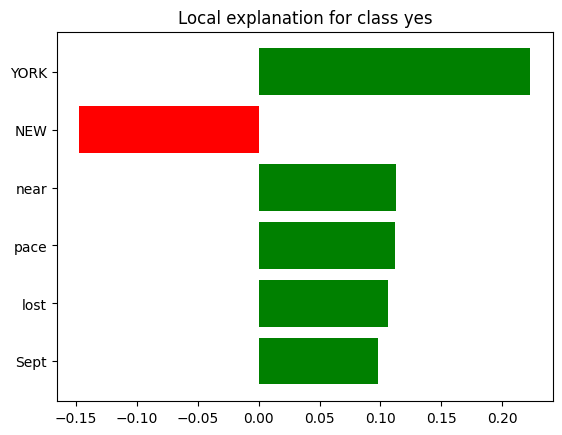

In [70]:
%matplotlib inline
fig = exp.as_pyplot_figure()